# Imports

Make sure the train.7z, train.txt, dev.txt and test.txt files are uploaded to the colab

In [ ]:
import nltk
!pip install lightgbm
import lightgbm
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
import gensim
from gensim.models import Word2Vec, FastText
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
!pip install --upgrade gensim
!pip install transformers
!pip install datasets 
!apt-get install p7zip-full
!p7zip -d train.7z
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, load_metric
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
     |████████████████████████████████| 4.0 MB 3.2 MB/s 
     |████████████████████████████████| 6.6 MB 36.0 MB/s 
     |████████████████████████████████| 596 kB 39.4 MB/s 
     |████████████████████████████████| 895 kB 51.6 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |█████████████████████████

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/bin/p7zip: cannot read train.7z


# Load data

In [ ]:
linesTrain = []
labelsTrain = []
linesTest = []
labelsTest = []
path = ''
with open(path+"train.txt") as file_in:
    for line in file_in:
        strippedLine = line.strip()
        if strippedLine != '' and strippedLine[:3] != '###':
            i = 0
            while strippedLine[i] != '\t':
                i+=1
            labelsTrain.append(strippedLine[:i])
            linesTrain.append(strippedLine[i+1:].lower())

with open(path + "test.txt") as file_in:
    for line in file_in:
        strippedLine = line.strip()
        if strippedLine != '' and strippedLine[:3] != '###':
            i = 0
            while strippedLine[i] != '\t':
                i+=1
            labelsTest.append(strippedLine[:i])
            linesTest.append(strippedLine[i+1:].lower())

In [ ]:
labelEncoder = LabelEncoder()
labels = ["BACKGROUND", "CONCLUSIONS","METHODS","OBJECTIVE","RESULTS"] #sort by names
labelEncoder.fit(labels)
Ytest = labelEncoder.transform(labelsTest)
Ytrain = labelEncoder.transform(labelsTrain)

Text(0, 0.5, 'Proportion in test set')

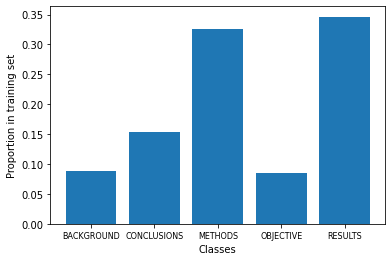

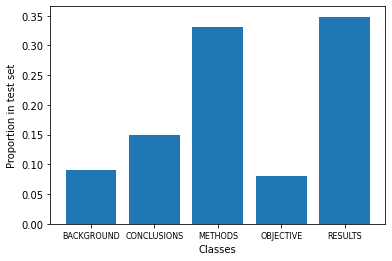

In [ ]:
class_names = [str(i) for i in range(5)]
labelsNumerical, counts = np.unique(Ytrain, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(labelsNumerical)
ax.set_xticklabels(labels,{'fontsize':8})
ax.set_xlabel('Classes')
ax.bar(labelsNumerical, counts/Ytrain.shape[0], align='center')
ax.set_ylabel("Proportion in training set")

labelsNumerical, counts = np.unique(Ytest, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(labelsNumerical)
ax.set_xticklabels(labels,{'fontsize':8})
ax.set_xlabel('Classes')
ax.bar(labelsNumerical, counts/Ytest.shape[0], align='center')
ax.set_ylabel("Proportion in test set")

Text(0, 0.5, 'Original test set')

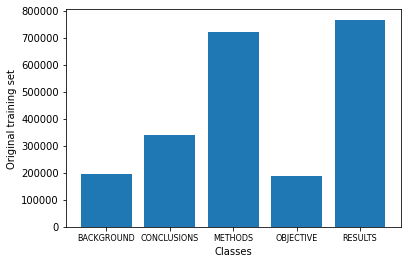

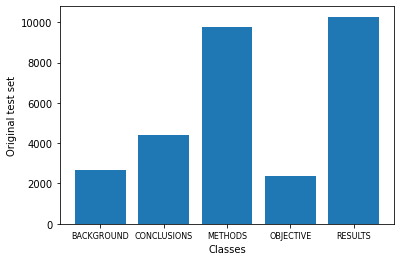

In [ ]:
class_names = [str(i) for i in range(5)]
labelsNumerical, counts = np.unique(Ytrain, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(labelsNumerical)
ax.set_xticklabels(labels,{'fontsize':8})
ax.set_xlabel('Classes')
ax.bar(labelsNumerical, counts, align='center')
ax.set_ylabel("Original training set")

labelsNumerical, counts = np.unique(Ytest, return_counts=True)
fig, ax = plt.subplots()
ax.set_xticks(labelsNumerical)
ax.set_xticklabels(labels,{'fontsize':8})
ax.set_xlabel('Classes')
ax.bar(labelsNumerical, counts, align='center')
ax.set_ylabel("Original test set")

# Code to plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Task 1

## Preprocessing

The sentences are already in lower case.

### Remove punctuation and digits

In [ ]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
#removing the punctuation char by char will let empty strings that we will have to remove in the arrays
for i in range(len(linesTest)):
  linesTest[i] = "".join(char for char in linesTest[i] if char not in string.punctuation and not char.isdigit())

for i in range(len(linesTrain)):
  linesTrain[i] = "".join(char for char in linesTrain[i] if char not in string.punctuation and not char.isdigit())

In [ ]:
print(linesTest[0])
print(linesTrain[0])

### Split to array

In [ ]:
trainSentences = []
testSentences = []

for i in range(len(labelsTest)):
    testSentences.append(linesTest[i].split(' '))

for i in range(len(labelsTrain)):
    trainSentences.append(linesTrain[i].split(' '))

In [ ]:
print(trainSentences[0])
print(testSentences[0])
print(len(testSentences),len(trainSentences))

### Remove stop-words and spaces 

#### Without stemming or lemmatisation

In [ ]:
for i in range(len(testSentences)):
  testSentences[i] = [word for word in testSentences[i] if word not in nltk.corpus.stopwords.words('english') and word!='']
np.save('testSentences.npy',testSentences)

In [ ]:
for i in range(len(trainSentences)):
  trainSentences[i] = [word for word in trainSentences[i] if word not in nltk.corpus.stopwords.words('english') and word!='']
np.save('trainSentences.npy',trainSentences)

#### With stemming

In [ ]:
stemmer = PorterStemmer()
for i in range(len(testSentences)):
  testSentences[i] = [stemmer.stem(word) for word in testSentences[i] if word not in nltk.corpus.stopwords.words('english') and word!='']
np.save('testSentencesStem.npy',testSentences)

In [ ]:
stemmer = PorterStemmer()
for i in range(len(trainSentences)):
  trainSentences[i] = [stemmer.stem(word) for word in trainSentences[i] if word not in nltk.corpus.stopwords.words('english') and word!='']
np.save('trainSentencesStem.npy',trainSentences)

#### With lemmatisation (with pos tag associated to each word)

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
lemmatizer = WordNetLemmatizer()
for i in range(len(testSentences)):
  newSentence = []
  for word in testSentences[i]:
    if word not in nltk.corpus.stopwords.words('english') and word!='':
      wordAndTag = nltk.pos_tag(nltk.word_tokenize(word))

      for word, tag in wordAndTag:
        tag = get_wordnet_pos(tag)
        if tag is None:
          newWord = lemmatizer.lemmatize(word)
        else:
          newWord = lemmatizer.lemmatize(word, pos=tag) 
        newSentence.append(newWord)

  testSentences[i] = newSentence
  
np.save('testSentencesLem.npy',testSentences)

In [ ]:
lemmatizer = WordNetLemmatizer()
for i in range(len(trainSentences)):
  newSentence = []
  for word in trainSentences[i]:
    if word not in nltk.corpus.stopwords.words('english') and word!='':
      wordAndTag = nltk.pos_tag(nltk.word_tokenize(word))

      for word, tag in wordAndTag:
        tag = get_wordnet_pos(tag)
        if tag is None:
          newWord = lemmatizer.lemmatize(word)
        else:
          newWord = lemmatizer.lemmatize(word, pos=tag) 
        newSentence.append(newWord)

  trainSentences[i] = newSentence
  
np.save('trainSentencesLem.npy',trainSentences)

## Load already Preprocessed data

In [ ]:
loadSentence = "" #load sentences without stemming nor lemmatisation

In [ ]:
if loadSentence == "stem":
  testSentences = np.load('testSentencesStem.npy',allow_pickle='TRUE')
elif loadSentence == "lemmatize":
  testSentences = np.load('testSentencesLem.npy',allow_pickle='TRUE')
else:
  testSentences = np.load('testSentences.npy',allow_pickle='TRUE')
print(testSentences[0])

['many', 'pathogenic', 'processes', 'diseases', 'result', 'erroneous', 'activation', 'complement', 'cascade', 'number', 'inhibitors', 'complement', 'thus', 'examined', 'antiinflammatory', 'actions']


In [ ]:
if loadSentence == "stem":
  trainSentences = np.load('trainSentencesStem.npy',allow_pickle='TRUE')
elif loadSentence == "lemmatize":
  trainSentences = np.load('trainSentencesLem.npy',allow_pickle='TRUE')
else:
  trainSentences = np.load('trainSentences.npy',allow_pickle='TRUE')
print(trainSentences[0])

['emergence', 'hiv', 'chronic', 'condition', 'means', 'people', 'living', 'hiv', 'required', 'take', 'responsibility', 'selfmanagement', 'condition', 'including', 'making', 'physical', 'emotional', 'social', 'adjustments']


In [ ]:
print(len(testSentences),len(trainSentences))

29493 2211861


## TF-IDF Embedding

In [ ]:
def returnSentencesArray(preprocessedArray):
  return preprocessedArray

In [ ]:
max_features = 1000
#vectorizer = TfidfVectorizer(max_features=max_features,analyzer='word',tokenizer=returnSentencesArray,preprocessor=returnSentencesArray,token_pattern=None)

#for MultinomialNB, min_df = 8
min_df = 8
max_df = 1.0
vectorizer = TfidfVectorizer(min_df = min_df, max_df = max_df, analyzer='word',tokenizer=returnSentencesArray,preprocessor=returnSentencesArray,token_pattern=None)

#for logistic regression, the best is to take all features
#vectorizer = TfidfVectorizer(analyzer='word',tokenizer=returnSentencesArray,preprocessor=returnSentencesArray,token_pattern=None)

vectorizer.fit(trainSentences)
Xtrain = vectorizer.transform(trainSentences)
Xtest = vectorizer.transform(testSentences)
print(Xtest.shape,Xtrain.shape)

(29493, 58737) (2211861, 58737)


## Downsampling and upsampling

Text(0, 0.5, 'Downsampled training set')

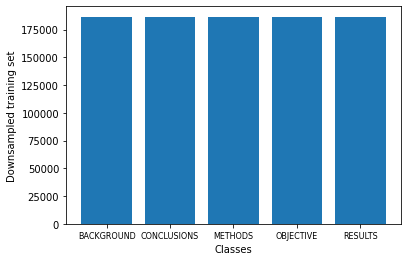

In [ ]:
Xtraind, Ytraind = RandomUnderSampler().fit_resample(Xtrain, Ytrain)
Xtestd, Ytestd = RandomUnderSampler().fit_resample(Xtest, Ytest)

class_names = [str(i) for i in range(5)]
labelsNumerical, counts = np.unique(Ytraind, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(labelsNumerical)
ax.set_xticklabels(labels,{'fontsize':8})
ax.set_xlabel('Classes')
ax.bar(labelsNumerical, counts, align='center')
ax.set_ylabel("Downsampled training set")

Text(0, 0.5, 'Proportion in training set')

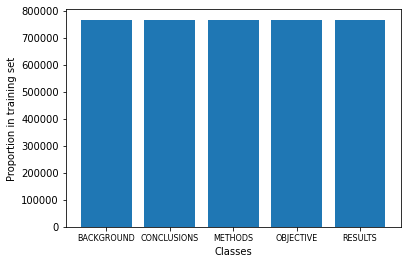

In [ ]:
Xtrainu, Ytrainu = RandomOverSampler().fit_resample(Xtrain, Ytrain)
Xtestu, Ytestu = RandomOverSampler().fit_resample(Xtest, Ytest)

class_names = [str(i) for i in range(5)]
labelsNumerical, counts = np.unique(Ytrainu, return_counts=True)

fig, ax = plt.subplots()
ax.set_xticks(labelsNumerical)
ax.set_xticklabels(labels,{'fontsize':8})
ax.set_xlabel('Classes')
ax.bar(labelsNumerical, counts, align='center')
ax.set_ylabel("Proportion in training set")

## Training on imbalanced and balanced datasets with MultinomialNB

In [ ]:
print(Xtrain.shape,Ytrain.shape)
print(Xtrainu.shape,Ytrainu.shape)
print(Xtraind.shape,Ytraind.shape)

(2211861, 58737) (2211861,)
(3831355, 58737) (3831355,)
(933005, 58737) (933005,)


In [ ]:
# See influence of having a balanced training and testing set
classifier = MultinomialNB() 
strategies = ["upsampling", "downsampling", "none"]

for strategy in strategies:
  if strategy == "upsampling":
    print("upsampling")
    classifier.fit(Xtrainu,Ytrainu)

  elif strategy == "downsampling":
    print("downsampling")
    classifier.fit(Xtraind,Ytraind)

  else:
    print("none")
    classifier.fit(Xtrain,Ytrain)

  model = classifier
  pred_test = model.predict(Xtest)
  pred_testu = model.predict(Xtestu)
  pred_testd = model.predict(Xtestd)

  print("original test set")
  f1 = f1_score(Ytest, pred_test, average="weighted")
  print("Test f1 score : %s "% f1)

  acc = accuracy_score(Ytest, pred_test)
  print("Test accuracy score : %s \n"% acc)

  print("upsampled test set")
  f1 = f1_score(Ytestu, pred_testu, average="weighted")
  print("Test f1 score : %s "% f1)

  acc = accuracy_score(Ytestu, pred_testu)
  print("Test accuracy score : %s \n"% acc)

  print("downsampled test set")
  f1 = f1_score(Ytestd, pred_testd, average="weighted")
  print("Test f1 score : %s "% f1)

  acc = accuracy_score(Ytestd, pred_testd)
  print("Test accuracy score : %s \n"% acc)

  if strategy == "upsampling":
    print("upsampling")
    pred_train = model.predict(Xtrainu)

    f1 = f1_score(Ytrainu, pred_train, average="weighted")
    print("Train f1 score : %s "% f1)

    acc = accuracy_score(Ytrainu, pred_train)
    print("Train accuracy score : %s \n"% acc)


  elif strategy == "downsampling":
    print("downsampling")
    pred_train = model.predict(Xtraind)

    f1 = f1_score(Ytraind, pred_train, average="weighted")
    print("Train f1 score : %s "% f1)

    acc = accuracy_score(Ytraind, pred_train)
    print("Train accuracy score : %s \n"% acc)

  else:
    print("none")
    pred_train = model.predict(Xtrain)

    f1 = f1_score(Ytrain, pred_train, average="weighted")
    print("Train f1 score : %s "% f1)

    acc = accuracy_score(Ytrain, pred_train)
    print("Train accuracy score : %s \n"% acc)

upsampling
original test set
Test f1 score : 0.7327158750848654 
Test accuracy score : 0.7258332485674567 

upsampled test set
Test f1 score : 0.6809879607230871 
Test accuracy score : 0.6814324639937719 

downsampled test set
Test f1 score : 0.684621293907842 
Test accuracy score : 0.6848969289019773 

upsampling
Train f1 score : 0.7047131407156367 
Train accuracy score : 0.7045282935149575 

downsampling
original test set
Test f1 score : 0.7342237220153778 
Test accuracy score : 0.7274946597497711 

upsampled test set
Test f1 score : 0.6853828411245192 
Test accuracy score : 0.6857532113662904 

downsampled test set
Test f1 score : 0.6886649275084689 
Test accuracy score : 0.6889356331510307 

downsampling
Train f1 score : 0.7067865407530513 
Train accuracy score : 0.7067282597628094 

none
original test set
Test f1 score : 0.7361798901900316 
Test accuracy score : 0.7449225239887431 

upsampled test set
Test f1 score : 0.6249737497403715 
Test accuracy score : 0.6385558583106267 

d

Test f1 score : 0.6270898155571483 
Test accuracy score : 0.640891880521666 

Normalized confusion matrix
[[4.16912074e-01 2.50736222e-01 1.35464872e-01 1.23264619e-01
  7.36222129e-02]
 [6.64703408e-02 6.33992427e-01 6.18426588e-02 1.09381573e-02
  2.26756416e-01]
 [6.73117375e-03 1.30416491e-02 8.60328145e-01 6.31047539e-03
  1.13588557e-01]
 [1.48927219e-01 1.36726967e-01 2.21287337e-01 4.45519562e-01
  4.75389146e-02]
 [3.36558687e-03 3.57593605e-02 1.12747160e-01 4.20698359e-04
  8.47707194e-01]]


<Figure size 432x288 with 0 Axes>

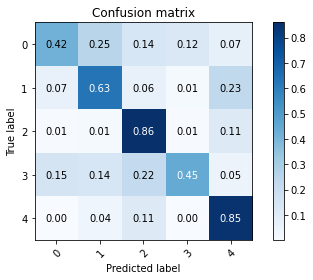

In [ ]:
#train on original data set but test on balanced dataset
classifier = MultinomialNB()
classifier.fit(Xtrain,Ytrain)
pred_testd = classifier.predict(Xtestd)

f1 = f1_score(Ytestd, pred_testd, average="weighted")
print("Test f1 score : %s "% f1)

acc = accuracy_score(Ytestd, pred_testd)
print("Test accuracy score : %s \n"% acc)

cnf_matrix = confusion_matrix(Ytestd, pred_testd)
class_names = [str(i) for i in range(5)]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Test f1 score : 0.6886649275084689 
Test accuracy score : 0.6889356331510307 

Normalized confusion matrix
[[0.59612958 0.12116113 0.04753891 0.21708035 0.01809003]
 [0.1531342  0.63273033 0.02692469 0.0778292  0.10938157]
 [0.03575936 0.02902819 0.79175431 0.05384939 0.08960875]
 [0.21161127 0.06310475 0.06226336 0.65082036 0.01220025]
 [0.02397981 0.08287758 0.1034918  0.01640724 0.77324358]]


<Figure size 432x288 with 0 Axes>

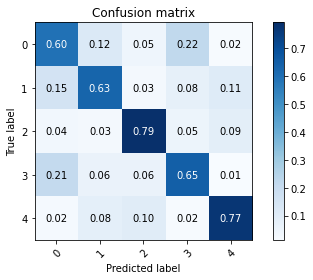

In [ ]:
#train on balanced dataset and test on balanced dataset
classifier = MultinomialNB()
classifier.fit(Xtraind,Ytraind)
pred_testd = classifier.predict(Xtestd)

f1 = f1_score(Ytestd, pred_testd, average="weighted")
print("Test f1 score : %s "% f1)

acc = accuracy_score(Ytestd, pred_testd)
print("Test accuracy score : %s \n"% acc)

cnf_matrix = confusion_matrix(Ytestd, pred_testd)
class_names = [str(i) for i in range(5)]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

## Choose best min_df of TF-IDF

In [ ]:
f1_scores = []
acc_scores = []
number_words = []
min_dfs = [i for i in range(1,20)]
print(min_dfs)
for i in range(len(min_dfs)):
  min_df = min_dfs[i]
  vectorizer = TfidfVectorizer(min_df = min_df, analyzer='word',tokenizer=returnSentencesArray,preprocessor=returnSentencesArray,token_pattern=None)
  vectorizer.fit(trainSentences)
  Xtrain = vectorizer.transform(trainSentences)
  Xtest = vectorizer.transform(testSentences)
  print(Xtest.shape,Xtrain.shape)
  model = MultinomialNB()
  #model = LogisticRegression(solver = "saga")
  model.fit(Xtrain,Ytrain)
  pred_train = model.predict(Xtrain)
  f1 = f1_score(Ytrain, pred_train, average="weighted")
  f1_scores.append(f1)  
  acc = accuracy_score(Ytrain, pred_train)
  acc_scores.append(acc)
  number_words.append(Xtrain.shape[1])

[1, 2, 3, 4, 5, 6, 7, 8, 9]
(29493, 247820) (2211861, 247820)
(29493, 146442) (2211861, 146442)
(29493, 112975) (2211861, 112975)
(29493, 93361) (2211861, 93361)
(29493, 80251) (2211861, 80251)
(29493, 71006) (2211861, 71006)
(29493, 64023) (2211861, 64023)
(29493, 58737) (2211861, 58737)
(29493, 54555) (2211861, 54555)


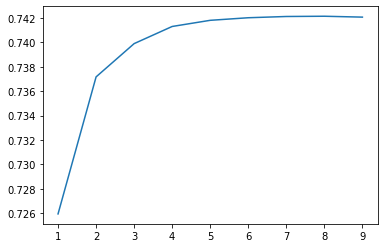

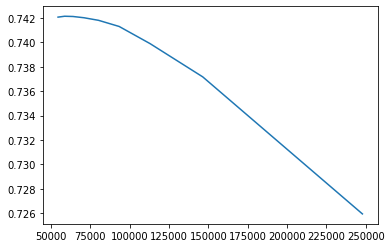

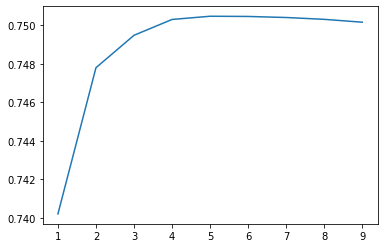

In [ ]:
plt.figure()
plt.plot(min_dfs,f1_scores)
plt.figure()
plt.plot(number_words,f1_scores)
plt.figure()
plt.plot(min_dfs,acc_scores)

In [ ]:
print("You need min_df =",min_dfs[np.argmax(f1_scores)])
print("F1 train score with multinomialNB :", np.max(f1_scores))
print("numbers of words :", number_words[np.argmax(f1_scores)])

You need min_df = 8
F1 train score with multinomialNB : 0.7421453539620375
numbers of words : 58737


## Best model and confusion matrix

In [ ]:
# classifiers = [
#     DecisionTreeClassifier(),
#     MultinomialNB(),
#     lightgbm.LGBMClassifier(),
#     LogisticRegression(solver = "saga"),
# ]

In [ ]:
classifier = LogisticRegression(solver = "saga")
classifier.fit(Xtrain,Ytrain)
pred_test = classifier.predict(Xtest)

f1 = f1_score(Ytest, pred_test, average="weighted")
print("Test f1 score : %s "% f1)

acc = accuracy_score(Ytest, pred_test)
print("Test accuracy score : %s \n"% acc)

Test f1 score : 0.7949881650166856 
Test accuracy score : 0.7979181500695081 



Normalized confusion matrix
[[0.54374765 0.15659031 0.09913631 0.16184754 0.03867818]
 [0.07252598 0.71531857 0.03999096 0.01965657 0.15250791]
 [0.00799918 0.01333197 0.90134345 0.0101528  0.0671726 ]
 [0.18258309 0.08245688 0.11569205 0.59823307 0.02103492]
 [0.00515765 0.0468081  0.09838459 0.00223822 0.84741144]]


<Figure size 432x288 with 0 Axes>

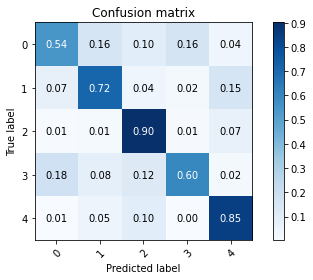

In [ ]:
cnf_matrix = confusion_matrix(Ytest, pred_test)
class_names = [str(i) for i in range(5)]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

# Task 2

You need to preprocess the data first

## Word2Vec models

In [ ]:
print(len(trainSentences),len(testSentences))

2211861 29493


In [ ]:
# train model

#model1 = Word2Vec(trainSentences, vector_size=50, window=5, min_count=1, workers=4)
model2 = Word2Vec(trainSentences, vector_size=100, window=5, min_count=1, workers=4)
#model3 = Word2Vec(trainSentences, vector_size=150, window=5, min_count=1, workers=4)
#model4 = Word2Vec(trainSentences, vector_size=200, window=5, min_count=1, workers=4)
#model5 = Word2Vec(trainSentences, vector_size=100, window=3, min_count=1, workers=4)
#model6 = Word2Vec(trainSentences, vector_size=300, window=5, min_count=1, workers=2)

#model7 = Word2Vec(trainSentences, vector_size=300, window=5, min_count=1, workers=4)
#modelStem = Word2Vec(trainSentencesStem, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# save model
#model1.save('model50.bin')
#model2.save('model100.bin')
#model3.save('model150.bin')
#model4.save('model200.bin')
#model5.save('model100_3.bin')
#model6.save('model300.bin')
#model7.save('model300.bin')
#modelStem.save('model1_Stem.bin')

In [ ]:
# load model
#modelStem = Word2Vec.load('model1_Stem.bin')
#model1 = Word2Vec.load('model100.bin')

## FastText models

In [ ]:
model_F1 = FastText(trainSentences, vector_size=100, window=3, min_count=1)
#model_F2 = FastText(trainSentences, vector_size=200, window=3, min_count=1)
#model_F3 = FastText(trainSentences, vector_size=100, window=2, min_count=1)
#model_F4 = FastText(trainSentences, vector_size=200, window=2, min_count=1)

In [ ]:
# save model
#model_F1.save('model_F100.bin')
#model_F2.save('model_F200.bin')
#model_F3.save('model_F100_2.bin')
#model_F4.save('model_F200_2.bin')
#model_F_Stem.save('model_F_Stem.bin')

In [ ]:
#model_F = Word2Vec.load('model_F100.bin')
#model_F_Stem = Word2Vec.load('model_F_Stem.bin')

## Pretrained Word2Vec

In [ ]:
vectors = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNewsvectorsnegative300.bin', binary=True)

## Sentence embedding : mean of word embeddings

In [ ]:
# mean of word embeddings or 0 if the words don't exist in vocabulary
def SentenceEmbedding(data, model_Word, arraysize):
    result = np.zeros((data.shape[0],arraysize))
    for i in range(data.shape[0]):
      sentence = data[i]
      for word in sentence:
        #for testing data we don't have all the words so we leave 0
        if word in model_Word.wv.key_to_index:
          result[i] += model_Word.wv[word]
      if len(sentence)>0:
        result[i]/=len(sentence)    
    return result

In [ ]:
# different function because the pretrained dataset is an old one
def SentenceEmbeddingPretrainedModel(data, model_Word):
    result = np.zeros((data.shape[0],300))
    for i in range(0,data.shape[0]):
        sentence = data[i]
        if len(sentence) > 0:
            if sentence[0] in model_Word.key_to_index:
                result[i,:] = model_Word[sentence[0]]
            else:
                result[i,:] = np.zeros((1,300))
                #result[i,:] = model.wv.most_similar(positive=[sentence[0]], negative=[])
                for j in range(1,len(sentence)):
                    if sentence[j] in model_Word.key_to_index:
                        result[i] = (result[i] + model_Word[sentence[j]])/2
                    else:
                        result[i] = (result[i] + np.zeros((1,300)))/2
                        # result[i] = (result[i] + model.wv.most_similar(positive=[sentence[0]], negative=[]))/2
    
    return result

In [ ]:
# trainSentencesEmb_pre = SentenceEmbedding(trainSentences, vectors)
# testSentencesEmb_pre = SentenceEmbedding(testSentences, vectors)

# trainSentencesEmbStem_pre = SentenceEmbedding(trainSentencesStem, vectors)
# testSentencesEmbStem_pre = SentenceEmbedding(testSentencesStem, vectors)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model2, 100)
testSentencesEmb = SentenceEmbedding(testSentences, model2, 100)

In [ ]:
print(trainSentencesEmb.shape,testSentencesEmb.shape)

(2211861, 100) (29493, 100)


In [ ]:
trainSentencesEmb_F1 = SentenceEmbedding(trainSentences, model_F1, 100)
testSentencesEmb_F1 = SentenceEmbedding(testSentences, model_F1, 100)

In [ ]:
# trainSentencesEmbStem = SentenceEmbedding(trainSentencesStem, modelStem, 100)
# testSentencesEmbStem = SentenceEmbedding(testSentencesStem, modelStem,100)

## Training and classification

In [ ]:
y_train = Ytrain
y_test = Ytest

In [ ]:
scaler = StandardScaler()

In [ ]:
def Scaler(train,test,scalerName):
    X_train = scalerName.fit_transform(train)
    X_test = scalerName.transform(test)
    return X_train, X_test

In [ ]:
# X_scaled_pre =  Scaler(trainSentencesEmb_pre,testSentencesEmb_pre,scaler)
# #X_scaledStem_pre =  Scaler(trainSentencesEmbStem_pre,testSentencesEmbStem_pre,scaler)

In [ ]:
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)
#X_scaled_F =  Scaler(trainSentencesEmb_F1,testSentencesEmb_F1,scaler)
#X_scaledStem =  Scaler(trainSentencesEmbStem,testSentencesEmbStem,scaler)

In [ ]:
def Classifier(X_train,X_test,y_train,y_test, modelClassifier):
    clf = modelClassifier.fit(X_train, y_train)
    pred_prob = clf.predict_proba(X_test)
    pred = clf.predict(X_test)
    print('Accuracy of classifier on training set: {:.4f}'
          .format(accuracy_score(y_test, pred)))
    print('AUROC of classifier on test set: {:.4f}'
             .format(roc_auc_score(y_test, pred_prob, multi_class = 'ovo')))
    print('F1 score of classifier on test set: {:.4f}'
             .format(f1_score(y_test, pred, average="macro")))  
    return pred

### Neural Network

In [ ]:
nn = MLPClassifier(hidden_layer_sizes = (50,),solver = 'adam',random_state=1, max_iter=300)

pred_nn = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, nn)

### KNN

In [ ]:
knn = KNeighborsClassifier(max_depth=7, random_state=0)

pred_knn = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, knn)

### Multinomial NB

In [ ]:
gnb = GaussianNB()

# pred_gnbStem = Classifier(X_scaledStem[0],X_scaledStem[1],y_train,y_test, gnb)
pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)
# pred_gnb_F = Classifier(X_scaled_F[0],X_scaled_F[1],y_train,y_test, gnb)

#pred_gnbStem_F = Classifier(X_scaledStem_F[0],X_scaledStem_F[1],y_train,y_test, gnb)
#pred_gnbStem_pre = Classifier(X_scaledStem_pre[0],X_scaledStem_pre[1],y_train,y_test, gnb)
#pred_gnb_pre = Classifier(X_scaled_pre[0],X_scaled_pre[1],y_train,y_test, gnb)

Accuracy of classifier on training set: 0.6422
AUROC of classifier on test set: 0.8494
F1 score of classifier on test set: 0.5619


In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model1, 50)
testSentencesEmb = SentenceEmbedding(testSentences, model1, 50)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model2, 100)
testSentencesEmb = SentenceEmbedding(testSentences, model2, 100)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model3, 150)
testSentencesEmb = SentenceEmbedding(testSentences, model3, 150)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model4, 200)
testSentencesEmb = SentenceEmbedding(testSentences, model4, 200)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model5, 100)
testSentencesEmb = SentenceEmbedding(testSentences, model5, 100)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model_F1, 100)
testSentencesEmb = SentenceEmbedding(testSentences, model_F1, 100)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model_F2, 200)
testSentencesEmb = SentenceEmbedding(testSentences, model_F2, 200)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model_F3, 100)
testSentencesEmb = SentenceEmbedding(testSentences, model_F3, 100)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

In [ ]:
trainSentencesEmb = SentenceEmbedding(trainSentences, model_F4, 200)
testSentencesEmb = SentenceEmbedding(testSentences, model_F4, 200)
X_scaled =  Scaler(trainSentencesEmb,testSentencesEmb,scaler)

pred_gnb = Classifier(X_scaled[0],X_scaled[1],y_train,y_test, gnb)

### Logistic regression

In [ ]:
classifier = LogisticRegression(solver = "saga")
print(trainSentencesEmb.shape,Ytrain.shape)

classifier.fit(trainSentencesEmb,Ytrain)
pred_test = classifier.predict(testSentencesEmb)
f1 = f1_score(Ytest, pred_test, average="weighted")
print("Test f1 score : %s "% f1)

acc = accuracy_score(Ytest, pred_test)
print("Test accuracy score : %s \n"% acc)

pred_train = classifier.predict(trainSentencesEmb)

f1 = f1_score(Ytrain, pred_train, average="weighted")
print("Train f1 score : %s "% f1)

acc = accuracy_score(Ytrain, pred_train)
print("Train accuracy score : %s \n"% acc)

(2211861, 100) (2211861,)
Test f1 score : 0.7328113468281303 
Test accuracy score : 0.7380734411555284 

Train f1 score : 0.7284466419898832 
Train accuracy score : 0.7335899498205357 



## Visualization of Embeddings

In [ ]:
model = model2

In [ ]:
# fit a 2d PCA model to the vectors
X = model.wv[model.wv.index_to_key]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.index_to_key)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.rcParams["figure.figsize"] = (50,50)
plt.show()

## Semantic relationships

In [ ]:
model.wv.most_similar(positive=['cancer', 'treatment'], negative=[])

[('therapy', 0.5981952548027039),
 ('chemotherapy', 0.59699547290802),
 ('adt', 0.5850258469581604),
 ('carcinoma', 0.5705400109291077),
 ('adenocarcinoma', 0.5670432448387146),
 ('radiotherapy', 0.5546224117279053),
 ('cancers', 0.5474623441696167),
 ('nsclc', 0.5358273386955261),
 ('chemoradiotherapy', 0.5350561738014221),
 ('carcinomas', 0.5090665221214294)]

In [ ]:
model.wv.most_similar(positive=['cancer', 'lump'], negative=[])

[('selfexamination', 0.8004909157752991),
 ('cancerspecific', 0.7884374260902405),
 ('cancers', 0.7829902172088623),
 ('carcinomaassociated', 0.7549611926078796),
 ('selfexam', 0.7426938414573669),
 ('adenocarcinoma', 0.742071270942688),
 ('gynecomastia', 0.7235526442527771),
 ('carcinogenesis', 0.7217583060264587),
 ('carcinomas', 0.721035897731781),
 ('carcinoma', 0.7202872037887573)]

In [ ]:
model.wv.most_similar(positive=['cancer', 'woman'], negative=[])

[('cancers', 0.6981176137924194),
 ('carcinoma', 0.6075315475463867),
 ('women', 0.5971040725708008),
 ('crc', 0.592994749546051),
 ('couples', 0.5862561464309692),
 ('adenocarcinoma', 0.5522218942642212),
 ('carcinomas', 0.5466548800468445),
 ('selfexamination', 0.543510913848877),
 ('partners', 0.5431241989135742),
 ('cancerspecific', 0.5382487773895264)]

In [ ]:
model.wv.most_similar(positive=['health', 'human'], negative=[])

[('heath', 0.5478385090827942),
 ('rights', 0.5298905968666077),
 ('ageing', 0.5269554257392883),
 ('farm', 0.5239627361297607),
 ('gutbrain', 0.5190560817718506),
 ('welfare', 0.5114969611167908),
 ('workerfamily', 0.5077306032180786),
 ('aging', 0.5067070722579956),
 ('healthpromoting', 0.4956786632537842),
 ('justice', 0.49528566002845764)]

In [ ]:
model.wv.most_similar(positive=['disease', 'women'], negative=['men'])

[('diseases', 0.5256254076957703),
 ('ileitis', 0.5022828578948975),
 ('ileocolitis', 0.45716652274131775),
 ('anticrc', 0.44415441155433655),
 ('vasculitis', 0.4392277002334595),
 ('borreliosis', 0.4344944357872009),
 ('illness', 0.42388835549354553),
 ('diseaseweight', 0.42109325528144836),
 ('baselinevstreatment', 0.4190898537635803),
 ('failure', 0.41428568959236145)]

In [ ]:
model.wv.most_similar(positive=['disease', 'men'], negative=['women'])

[('diseases', 0.5390373468399048),
 ('ileitis', 0.5217354893684387),
 ('atherosclerosis', 0.5045921802520752),
 ('calcification', 0.4862903654575348),
 ('cardiomyopathy', 0.4651171565055847),
 ('fibrosis', 0.4648686647415161),
 ('nonbevacizumabtreated', 0.46118056774139404),
 ('emphysema', 0.45085158944129944),
 ('diseaserelated', 0.4446144104003906),
 ('nonhemochromatotic', 0.43893247842788696)]

In [ ]:
model.wv.most_similar(positive=['cancer'], negative=['treatment'])

[('cancerspecific', 0.6213210821151733),
 ('plco', 0.5832172632217407),
 ('carcinogenesis', 0.5607367753982544),
 ('carcinoma', 0.5454698801040649),
 ('cancers', 0.5433659553527832),
 ('selfexamination', 0.5414717197418213),
 ('selfexam', 0.5405081510543823),
 ('adenocarcinoma', 0.5357382297515869),
 ('endocoil', 0.5349986553192139),
 ('carcinomaassociated', 0.520575761795044)]

# Task 3

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
dataset = load_dataset('text', data_files={'train': ['train.txt'], 'dev':['dev.txt'], 'test':['test.txt']})

In [ ]:
#Creating the labels
label_mapping = {"BACKGROUND":0,"OBJECTIVE":1,"METHODS":2,"RESULTS":3,"CONCLUSIONS":4}

filtered_dataset = dataset.filter(lambda one_sentence: one_sentence['text'].split("\t")[0] in label_mapping.keys())

def generate_labels(one_sentence):
  return {'label':label_mapping[one_sentence["text"].split("\t")[0]] ,'text':one_sentence["text"]}

labelled_dataset = filtered_dataset.map(generate_labels, batched=False)

In [ ]:
max_length = 256
def tokenize_function_max(one_sentence):
    return tokenizer(one_sentence["text"], padding="max_length", truncation=True, max_length=max_length)

def tokenize_function_simple(one_sentence):
    return tokenizer(one_sentence["text"])

tokenized_dataset2 = labelled_dataset.map(tokenize_function_max, batched=True)

tokenized_dataset = labelled_dataset.map(tokenize_function_simple, batched=True)

In [ ]:
small_train2 = tokenized_dataset2["train"].shuffle(seed=42).select(range(50000))
small_dev2 = tokenized_dataset2["dev"].shuffle(seed=42).select(range(1000))

In [ ]:
#See below for meaning of suffixes
model_T0 = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=5)
model_T1 = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=5)
model_T2 = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=5)

In [ ]:
#using 5 epochs
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=5)

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## T0: No fine-tuning (just training classifier head)

In [ ]:
for param in model_T0.base_model.parameters():
    param.requires_grad = False

In [ ]:
trainer_T0 = Trainer(
    model=model_T0,
    args=training_args,
    train_dataset= small_train2,
    eval_dataset= small_dev2,
    compute_metrics= compute_metrics,
)

In [ ]:
sum(p.numel() for p in model_T0.parameters() if p.requires_grad)
#Checking number of trainable parameters to ensure correct freezing

In [ ]:
trainer_T0.train()

In [ ]:
testing_args = TrainingArguments(output_dir="eval_trainer", evaluation_strategy="epoch", per_device_train_batch_size=16, per_device_eval_batch_size=16, num_train_epochs=5)

metric = load_metric("accuracy")
def compute_metrics_testing(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    print(f"weighted f1_score: {f1_score(labels, predictions,  average='weighted')}")
    print(f"accuracy: {confusion_matrix(labels, predictions, normalize ='true')}")
    return metric.compute(predictions=predictions, references=labels)

eval_trainer_T0 = Trainer(
    model=model_T0,
    args=testing_args,
    eval_dataset= tokenized_dataset2["test"],
    compute_metrics= compute_metrics_testing,
)

In [ ]:
eval_trainer_T0.evaluate()

## T1: Fine-tuning (last BERT layer)

In [ ]:
for param in model_T1.base_model.parameters():
    param.requires_grad = False
for param in model_T1.base_model.encoder.layer[11].parameters():
    param.requires_grad = True

In [ ]:
trainer_T1 = Trainer(
    model=model_T1,
    args=training_args,
    train_dataset= small_train2,
    eval_dataset= small_dev2,
    compute_metrics= compute_metrics,
)

In [ ]:
trainer_T1.train()

In [ ]:
metric = load_metric("accuracy")

eval_trainer_T1 = Trainer(
    model=model_T1,
    args=testing_args,
    eval_dataset= tokenized_dataset2["test"],
    compute_metrics= compute_metrics_testing,
)

In [ ]:
eval_trainer_T1.evaluate()

## T2: Fine-tuning (last 2 BERT layers)

In [ ]:
for param in model_T2.base_model.parameters():
    param.requires_grad = False
for param in model_T2.base_model.encoder.layer[10].parameters():
    param.requires_grad = True
for param in model_T2.base_model.encoder.layer[11].parameters():
    param.requires_grad = True

In [ ]:
trainer_T2 = Trainer(
    model=model_T2,
    args=training_args,
    train_dataset= small_train2,
    eval_dataset= small_dev2,
    compute_metrics= compute_metrics,
)

In [ ]:
trainer_T2.train()

In [ ]:
metric = load_metric("accuracy")

eval_trainer_T2 = Trainer(
    model=model_T2,
    args=testing_args,
    eval_dataset= tokenized_dataset2["test"],
    compute_metrics= compute_metrics_testing,
)

In [ ]:
eval_trainer_T2.evaluate()